In [2]:
from mpi4py import MPI
import numpy as np
import h5py
import dxchange
import torch as tc
import os
import torch as tc
import torch.nn.functional as F
from tqdm import tqdm
import csv
import types
import matplotlib.font_manager
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib 
# matplotlib.font_manager._rebuild()
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

fontProperties = {'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

import matplotlib as mpl
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from matplotlib.colors import SymLogNorm

In [3]:
def rotate(arr, theta, dev):
 
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0.0], device=dev)
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1])
    
    g = F.affine_grid(m, arr.shape)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${}\,10^{{{}}}$'.format(a, b)

def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymax
    self.offsetText.set(va="top", ha="left")
    self.offsetText.set_position(
            (-0.5, bottom - self.OFFSETTEXTPAD * self.figure.dpi / 72.0 + 25.0))

In [50]:
## For a 64 x 64 x 64 sample_8_size_64_test  ##
######################################################################
dev = 'cpu'
# experiemtal parameters #
# theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1].to(dev)
sample_size_n = tc.tensor(64).to(dev)
sample_height_n = tc.tensor(64).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"Ca": 20, "Sc": 21}
probe_energy = np.array([20.0])
det_size_cm = 0.9
det_from_sample_cm = 1.6
det_ds_spacing_cm = 0.4

# path of true grid concentration of the sample #
grid_path = './data/sample8_size_64_pad/nElements_2'
f_grid = 'grid_concentration.npy'

# XRF and XRT data path #


# path of storing the intersecting information and the reconstructing results #
recon_path = './data/sample_8_size_64_test_recon_probeAtt_False'
# recon_path = './data/sample_8_size_64_test_recon_Ab_XRFT_b1_10E4_b2_1E0'
# recon_path = './data/sample_8_size_64_test_recon_XRFT_b1_10E4_b2_1E0'
f_recon_parameters = 'recon_parameters.txt'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
######################################################################

2.3820097


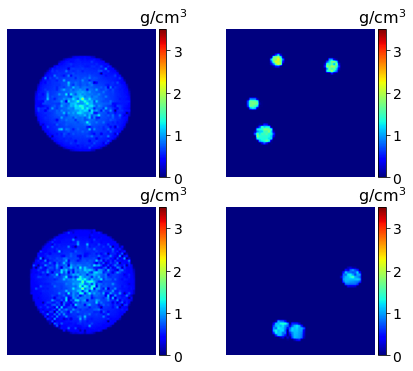

In [48]:
layer_idx_ls = np.array([30, 40])

linthresh = 0.001
linscale = 0.3

with h5py.File(os.path.join(recon_path, f_recon_grid +'.h5'), "r") as s:
    recon = s["sample/densities"][...].astype(np.float32)

image_size = recon.shape[-1]
fig6 = plt.figure(figsize=(4 * recon.shape[0] * 0.9 , 3 * len(layer_idx_ls)))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = recon.shape[0], width_ratios=[1] * recon.shape[0])

vmax_element_ls = [3.5, 3.5]
# fig6.text(0.27, 0.885, 'Ca', color='black', fontsize=24)
# fig6.text(0.70, 0.885, 'Sc', color='black', fontsize=24)
print(np.max(recon))
for element_idx in range(recon.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
#         pos = fig6_ax1.imshow(recon[element_idx,layer_idx], cmap='jet', vmin=0, vmax=np.max(recon[element_idx]), extent=[0., image_size, image_size, 0.], origin='upper')
        pos = fig6_ax1.imshow(recon[element_idx,layer_idx], cmap='jet', vmin=0, vmax=vmax_element_ls[element_idx], extent=[0., image_size, image_size, 0.], origin='upper')
#         pos = fig6_ax1.imshow(recon[element_idx,layer_idx], cmap='jet', vmin=0, vmax=np.ceil(np.max(recon[element_idx])), extent=[0., image_size, image_size, 0.], origin='upper')
#         pos = fig6_ax1.imshow(recon[element_idx,layer_idx], cmap='jet', norm=SymLogNorm(linthresh=linthresh, linscale=linscale, base=10, vmin=0, vmax=np.max(recon[element_idx])), extent=[0., image_size, image_size, 0.], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05) 
#         ticks = np.arange(0, np.ceil(np.max(recon[element_idx]))+2, 1)
#         cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar = fig6.colorbar(pos, cax=cax)
#         cbar.ax.set_yticklabels(["{:.1f}".format(i) for i in ticks])
        cbar.ax.tick_params(labelsize=14) 
        cbar.ax.set_title('g/'+r'$\rm{cm}^{3}$', size='16')
        
plt.savefig(os.path.join(recon_path, 'recon_layer_section.pdf'))

(2, 64, 64, 64)
7044.008933007717
3237.693337723613


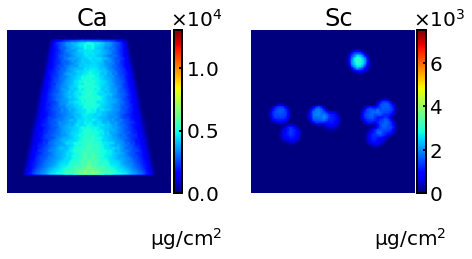

In [51]:
rotational_degree = 45
projection_angle = rotational_degree*tc.tensor(np.pi/180)
# recon = np.load(os.path.join(recon_path, f_recon_grid + '.npy'))
with h5py.File(os.path.join(recon_path, f_recon_grid +'.h5'), "r") as s:
    recon = s["sample/densities"][...].astype(np.float32)

recon = rotate(tc.from_numpy(recon), projection_angle, "cpu")
recon = recon.numpy()
print(recon.shape)

smaple_height = recon.shape[1]
image_size = recon.shape[-1]

## convert the unit to ug/cm^2
recon_proj = np.sum(recon, axis=-1)*np.array((sample_size_cm/sample_size_n))*10**6

## convert the unit to g/cm^2
# recon_proj = np.sum(recon, axis=-1)*np.array((sample_size_cm/sample_size_n))

fig6 = plt.figure(figsize=(4 * recon.shape[0]  , 3))
gs6 = gridspec.GridSpec(nrows= 1, ncols = recon.shape[0], width_ratios=[1] * recon.shape[0])

fig6.text(0.27, 0.9, 'Ca', color='black', fontsize=24)
fig6.text(0.70, 0.9, 'Sc', color='black', fontsize=24)

vmax_element_ls = [13000, 7500]
for element_idx in range(recon.shape[0]):
    print(np.max(recon_proj[element_idx]))
    fig6_ax1 = fig6.add_subplot(gs6[0, element_idx])
    fig6_ax1.set_xticks(np.arange(0, image_size, 1))
    fig6_ax1.set_yticks(np.arange(0, image_size, 1))
    # fig6_ax1.grid(color='w', linewidth=2)
    fig6_ax1.axis('off')
    pos = fig6_ax1.imshow(recon_proj[element_idx], cmap='jet', vmin=0, vmax=vmax_element_ls[element_idx], extent=[0, image_size, smaple_height, 0], origin='upper')
#     pos = fig6_ax1.imshow(recon_proj[element_idx], cmap='jet', vmin=0, vmax=recon_proj[element_idx].max(), extent=[0, image_size, smaple_height, 0], origin='upper')
#     pos = fig6_ax1.imshow(recon_proj[element_idx], cmap='jet', norm=SymLogNorm(linthresh=linthresh, linscale=linscale, base=10, vmin=0, vmax=vmax_element_ls[element_idx]), extent=[0, image_size, smaple_height, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#         ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
#         cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)

    ## change the base of the scientific notation from "e" to "10"
    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = fig6.colorbar(pos, cax=cax, format=fmt)
#     cbar = fig6.colorbar(pos, cax=cax,format=ticker.FuncFormatter(fmt))
    
    ## set the fontsize of the tick label
    cbar.ax.tick_params(labelsize=20, direction='in', width=2)
    ## set the linewidth of the colorbar box
    cbar.outline.set_linewidth(2)
    
    ## Change the size of the base of the scientific notation 
    cbar.ax.yaxis.get_offset_text().set_fontsize(20)
    
    ## Move the base of the scientific notation to the bottom of the colorbar
    def register_bottom_offset(axis, func):
        axis._update_offset_text_position = types.MethodType(func, axis)    
    register_bottom_offset(cbar.ax.yaxis, bottom_offset)    
    
    ## Move the label of the colorbar to the wanted position
    cbar.set_label(r'$\rm{\mu}$g/'+r'$\rm{cm}^{2}$', y=-0.20, ha='right', rotation=0, va='top', size='20')
    
#     cbar.ax.set_title(r'$\rm{\mu}$g/'+r'$\rm{cm}^{2}$', size='20')
#     cbar.ax.set_title(r'$\rm{g}/$'+r'$\rm{cm}^{2}$', size='20')

plt.savefig(os.path.join(recon_path, f'recon_projection_{rotational_degree}_degree.pdf'))

# Plot the sinogram from the raw data

In [41]:
######################################################################
# XRF and XRT data path #
data_path = './data/sample_8_size_64_test'
f_XRF_data = 'test8_xrf'
f_XRT_data = 'test8_xrt'

y1_true_handle = h5py.File(os.path.join(data_path, f_XRF_data), 'r')
y2_true_handle = h5py.File(os.path.join(data_path, f_XRT_data), 'r') 

element_lines_roi_idx = np.array([0, 1, 2, 3])
photon_counts_us_ic_dataset_idx = 1
photon_counts_ds_ic_dataset_idx = 2
photon_counts_abs_ic_dataset_idx = 3

dev = 'cpu'
# experiemtal parameters #
theta_ls = tc.from_numpy(y1_true_handle['exchange/theta'][...] * np.pi / 180).float().to(dev)
n_theta = len(theta_ls)
sample_size_n = 64
sample_height_n = 64
sample_size_cm = 0.01
this_aN_dic = {"Ca": 20, "Sc": 12}
n_elements = 4
probe_energy = np.array([20.0])
det_size_cm = 2.4
det_from_sample_cm = 3.0
det_ds_spacing_cm = 2.4/2


XRF_data = y1_true_handle['exchange/data'][...]
XRT_data = y2_true_handle['exchange/data'][...]
print(XRF_data.shape)
print(XRT_data.shape)
XRF_data = np.reshape(y1_true_handle['exchange/data'][element_lines_roi_idx], (len(element_lines_roi_idx), n_theta, sample_height_n * sample_size_n))
XRT_data = np.reshape(y2_true_handle['exchange/data'][photon_counts_abs_ic_dataset_idx], (n_theta, sample_height_n * sample_size_n))
print(XRF_data.shape)
print(XRT_data.shape)

theta = y2_true_handle['exchange/theta'][...]

y1_true_handle.close()
y2_true_handle.close()

(4, 200, 64, 64)
(4, 200, 64, 64)
(4, 200, 4096)
(200, 4096)


## Plot the XRF sinogram from raw data

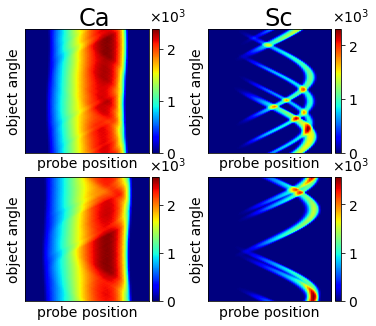

In [15]:
# layer_idx_ls = np.arange(0, 64, 16)
# layer_idx_ls = np.arange(0, 32, 8)
layer_idx_ls = np.array([30, 40])

n_elements = len(this_aN_dic)
line_idx_all_elements_ls = [[0,1], [2,3]]
n_theta_ds_factor = 1

fig6 = plt.figure(figsize=(6, 5))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=n_elements)
fig6.text(0.270, 0.89, 'Ca', color='black', fontsize=24)
fig6.text(0.700, 0.89, 'Sc', color='black', fontsize=24)

for i_element in range(n_elements):
    max_XRF_data_this_line = 0.
    for idx, layer_idx in enumerate(layer_idx_ls):
        probe_pos_st = sample_size_n * layer_idx
        probe_pos_end = sample_size_n * (layer_idx + 1)
        XRF_data_ds = np.zeros(XRF_data[0, ::n_theta_ds_factor, probe_pos_st:probe_pos_end].shape)
        line_idx_ls = line_idx_all_elements_ls[i_element]
        for line_idx in line_idx_ls:
            XRF_data_ds += XRF_data[line_idx, ::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#         XRF_data_ds = np.transpose(XRF_data_ds, (1,0))
        max_XRF_data_this_line = np.max(np.array([max_XRF_data_this_line, np.max(XRF_data_ds)]))
        fig6_ax1 = fig6.add_subplot(gs6[idx, i_element])
#         pos = fig6_ax1.imshow(XRF_data_ds, cmap='jet', vmin=0, vmax=max_XRF_data_this_line, extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='lower')    
        pos = fig6_ax1.imshow(XRF_data_ds, cmap='jet', vmin=0, vmax=np.max(XRF_data_ds), extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='upper')
        plt.setp(fig6_ax1.get_xticklabels(), visible=False)
        plt.setp(fig6_ax1.get_yticklabels(), visible=False)
        fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
#         ticks = np.arange(0, 12000, 2000)
#         cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar = fig6.colorbar(pos, cax=cax) 
        cbar.ax.tick_params(labelsize=14) 
        cbar.formatter.set_powerlimits((0, 0))
        fig6_ax1.set_ylabel("object angle", fontsize=14)
        fig6_ax1.set_xlabel("probe position", fontsize=14)
        
        
        ## change the base of the scientific notation from "e" to "10"
        fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((0, 0))
        cbar = fig6.colorbar(pos, cax=cax, format=fmt) 

        ## Change the size of the base of the scientific notation 
        cbar.ax.yaxis.get_offset_text().set_fontsize(14)

        ## Move the base of the scientific notation to the bottom of the colorbar
        def register_bottom_offset(axis, func):
            axis._update_offset_text_position = types.MethodType(func, axis)    
        register_bottom_offset(cbar.ax.yaxis, bottom_offset) 
    
plt.savefig(os.path.join(data_path, 'XRF_sinogram.pdf'), format='pdf', dpi=300)

## Plot the XRF sinogram averaged over all channels (from raw data)

(4, 200, 4096)
219.62117
0.0
637.107
724.1018
580.6029


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


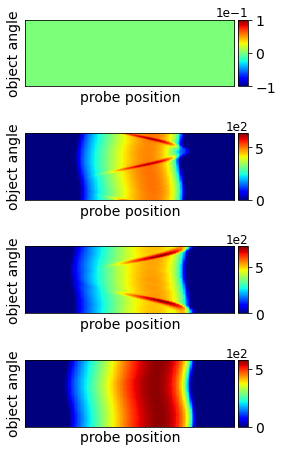

In [12]:
# layer_idx_ls = np.arange(0, 64, 16)
layer_idx_ls = np.array([30, 40])
n_elements = len(this_aN_dic)
line_idx_all_elements_ls = [[0], [1]]
# line_idx_all_elements_ls = [[0], [1], [2], [3]]
n_theta_ds_factor = 1

print(XRF_data.shape) # (n_theta, n_lines, n_probe_pos)
print(np.mean(XRF_data))

fig6 = plt.figure(figsize=(4, 8))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)
fig6.text(0.270, 0.89, 'Ca', color='black', fontsize=24)
fig6.text(0.700, 0.89, 'Sc', color='black', fontsize=24)


for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRF_data_ds = np.zeros(XRF_data[:, ::n_theta_ds_factor, probe_pos_st:probe_pos_end].shape)

    XRF_data_ds = XRF_data[:, ::n_theta_ds_factor, probe_pos_st:probe_pos_end]
    XRF_data_ds_mean = np.mean(XRF_data_ds, axis=0)

#         XRF_data_ds = np.transpose(XRF_data_ds, (1,0))
    fig6_ax1 = fig6.add_subplot(gs6[idx, 0])
    pos = fig6_ax1.imshow(XRF_data_ds_mean, cmap='jet', vmin=0, vmax=np.max(XRF_data_ds_mean), extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='lower')
#         pos = fig6_ax1.imshow(XRF_data_ds, cmap='jet', vmin=0, vmax=10000, extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='lower')
    print(np.max(XRF_data_ds_mean))
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#         ticks = np.arange(0, 12000, 2000)
#         cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax) 
    cbar.ax.tick_params(labelsize=14) 
    cbar.formatter.set_powerlimits((0, 0))
    fig6_ax1.set_ylabel("object angle", fontsize=14)
    fig6_ax1.set_xlabel("probe position", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')

# plt.savefig(os.path.join(data_path, 'XRF_sinogram_channel_ave.pdf'), format='pdf', dpi=300)

## Plot the XRT sinogram (Transmission ratio) from raw data

1.0
1.0


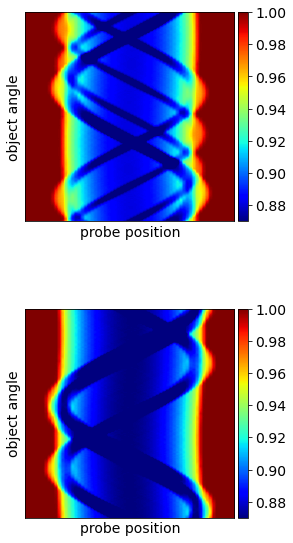

In [19]:
# layer_idx_ls = np.arange(0, 64, 16)
layer_idx_ls = np.array([30, 40])
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n * sample_size_n))
n_elements = len(this_aN_dic)
n_theta_cpu =  n_theta
n_theta_ds_factor = 1
# print(np.max(XRT_data))
# print(np.min(XRT_data))

# fig6 = plt.figure(figsize=(20, 30))
fig6 = plt.figure(figsize=(4, 10))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
    print(np.max(XRT_data_ds))
    fig6_ax1 = fig6.add_subplot(gs6[idx])
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=180000, vmax= np.max(XRT_data), extent=[0, 110, 44, 0], origin='upper')
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.87, vmax= 1.0, extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='upper')
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.0, extent=[0, XRF_data_ds.shape[1], probe_pos_end-probe_pos_st, 0], origin='upper')
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.80, vmax= 0.95, origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([180000, 200000])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=14)
    fig6_ax1.set_ylabel("object angle", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig(os.path.join(data_path, 'OD_sinogram.pdf'), format='pdf', dpi=300)

0.22916305
0.12639205
0.163194


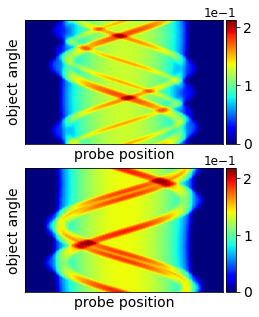

In [22]:
layer_idx_ls = np.array([30, 40])
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n * sample_size_n))
XRT_data_OD = - np.log(XRT_data)
n_elements = len(this_aN_dic)
n_theta_cpu =  n_theta
n_theta_ds_factor = 1
print(np.max(XRT_data_OD))

# fig6 = plt.figure(figsize=(20, 30))
fig6 = plt.figure(figsize=(5,5))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data_OD[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data_OD[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
#     print(np.max(XRT_data_ds))
    fig6_ax1 = fig6.add_subplot(gs6[idx])
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', extent=[0, 176, 110, 0], origin='upper')
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', extent=[0, XRT_data_ds.shape[0], probe_pos_end-probe_pos_st, 0], origin='upper')
#     print(np.max(XRT_data_ds))
    print(XRT_data_ds[54, 22])
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.80, vmax= 0.95, origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([180000, 200000])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=14)
    fig6_ax1.set_ylabel("object angle", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig(os.path.join(data_path, 'OD_sinogram.pdf'), format='pdf', dpi=300)

3.8448362
0.27355838
0.25738755
0.2426119
0.25078043


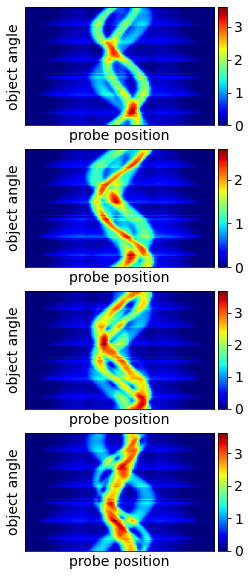

In [433]:
layer_idx_ls = np.arange(0, 32, 8)
XRT_data = np.reshape(XRT_data, (n_theta, sample_height_n * sample_size_n))
XRT_data_OD = - np.log(XRT_data)
n_elements = len(this_aN_dic)
n_theta_cpu =  n_theta
n_theta_ds_factor = 1
print(np.max(XRT_data_OD))

# fig6 = plt.figure(figsize=(20, 30))
fig6 = plt.figure(figsize=(10,10))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data_OD[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data_OD[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
#     print(np.max(XRT_data_ds))
    fig6_ax1 = fig6.add_subplot(gs6[idx])
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', extent=[0, 176, 110, 0], origin='upper')
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', extent=[0, XRT_data_ds.shape[0], probe_pos_end-probe_pos_st, 0], origin='upper')
#     print(np.max(XRT_data_ds))
    print(XRT_data_ds[54, 22])
#     pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=0.80, vmax= 0.95, origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([180000, 200000])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=14)
    fig6_ax1.set_ylabel("object angle", fontsize=14)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig(os.path.join(data_path, 'OD_sinogram.pdf'), format='pdf', dpi=300)

(4, 200, 4096)


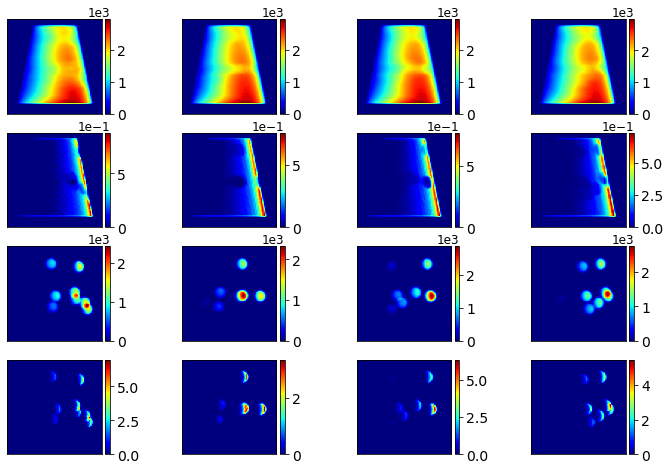

In [14]:
theta_idx_ls = np.array([0, 113, 135, 158])
XRF_data_projection =  np.reshape(XRF_data, (len(element_lines_roi_idx), n_theta, sample_height_n, sample_size_n))
print(XRF_data.shape)

fig6 = plt.figure(figsize=(12, 8))
gs6 = gridspec.GridSpec(len(element_lines_roi_idx), ncols=len(theta_idx_ls))

# fig6.text(0.088, 0.8, 'Al', color='black', fontsize=22)
# fig6.text(0.088, 0.6, 'Si', color='black', fontsize=22)
# fig6.text(0.088, 0.4, 'Fe', color='black', fontsize=22)
# fig6.text(0.088, 0.2, 'Cu', color='black', fontsize=22)

# fig6.text(0.15, 0.88, r'$-165^\degree$', color='black', fontsize=22)
# fig6.text(0.36, 0.88, r'$-1.5^\degree$', color='black', fontsize=22)
# fig6.text(0.57, 0.88, r'$43.9^\degree$', color='black', fontsize=22)
# fig6.text(0.78, 0.88, r'$165^\degree$', color='black', fontsize=22)

# fig6.text(0.088, 0.8, 'Al', color='black', fontsize=22)
# fig6.text(0.088, 0.6, 'Si', color='black', fontsize=22)
# fig6.text(0.088, 0.4, 'Fe', color='black', fontsize=22)
# fig6.text(0.088, 0.2, 'Cu', color='black', fontsize=22)

# fig6.text(0.15, 0.88, r'$0^\degree$', color='black', fontsize=22)
# fig6.text(0.36, 0.88, r'$46^\degree$', color='black', fontsize=22)
# fig6.text(0.57, 0.88, r'$90^\degree$', color='black', fontsize=22)
# fig6.text(0.78, 0.88, r'$136^\degree$', color='black', fontsize=22)

for idx, theta_idx in enumerate(theta_idx_ls):
    for line_idx in range(len(element_lines_roi_idx)):              
        fig6_ax1 = fig6.add_subplot(gs6[line_idx, idx])                                        
        pos = fig6_ax1.imshow(XRF_data_projection[line_idx, theta_idx], cmap='jet', vmin=0, vmax = np.max(XRF_data_projection[line_idx, theta_idx]), origin='upper')
#         pos = fig6_ax1.imshow(XRF_data_projection[line_idx, theta_idx], cmap='jet', vmin=0, vmax=1000, extent=[0, n_theta, 64, 0], origin='upper')
        plt.setp(fig6_ax1.get_xticklabels(), visible=False)
        plt.setp(fig6_ax1.get_yticklabels(), visible=False)
        fig6_ax1.tick_params(axis='both', which='both', length=0)                        
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)                        
        cbar = fig6.colorbar(pos, cax=cax) 
        cbar.ax.tick_params(labelsize=14) 
        cbar.formatter.set_powerlimits((0, 0))                        

plt.savefig(os.path.join(data_path, 'XRF_signal_projection.pdf'), format='pdf', dpi=300)

(4, 110, 20, 44)


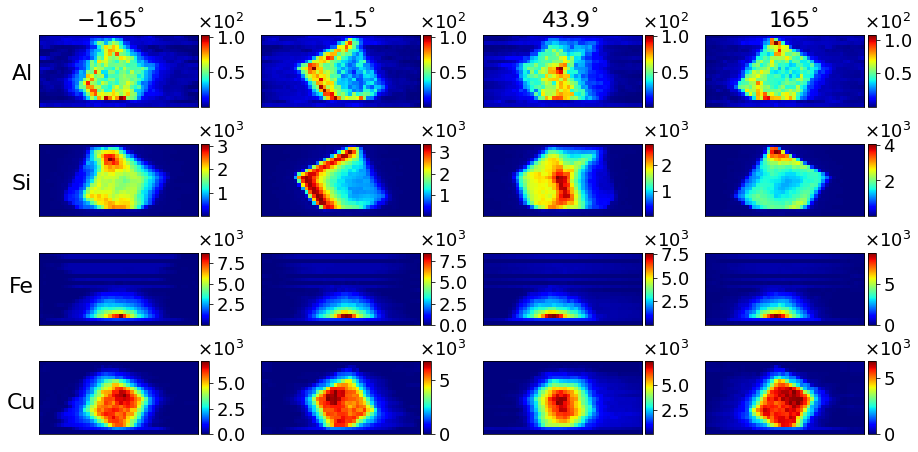

In [ ]:
theta_idx_ls = np.array([0, 54, 69, 109])
# theta_idx_ls = np.array([0, 54, 69, 109])
# theta_idx_ls = np.array([0, 30, 90, 99])

XRF_data_projection =  np.reshape(XRF_data, (XRF_data.shape[0], XRF_data.shape[1], sample_height_n, sample_size_n))
print(XRF_data_projection.shape)

fig6 = plt.figure(figsize=(15, 8))
gs6 = gridspec.GridSpec(XRF_data.shape[0], ncols=len(theta_idx_ls))

fig6.text(0.1, 0.77, 'Al', color='black', fontsize=22)
fig6.text(0.1, 0.58, 'Si', color='black', fontsize=22)
fig6.text(0.098, 0.4, 'Fe', color='black', fontsize=22)
fig6.text(0.096, 0.2, 'Cu', color='black', fontsize=22)

fig6.text(0.16, 0.86, r'$-165^\degree$', color='black', fontsize=22)
fig6.text(0.38, 0.86, r'$-1.5^\degree$', color='black', fontsize=22)
fig6.text(0.59, 0.86, r'$43.9^\degree$', color='black', fontsize=22)
fig6.text(0.80, 0.86, r'$165^\degree$', color='black', fontsize=22)

gs6.update(wspace=0.3, hspace=0.005)

for idx, theta_idx in enumerate(theta_idx_ls):
    for line_idx in range(XRF_data.shape[0]):              
        fig6_ax1 = fig6.add_subplot(gs6[line_idx, idx])                                        
#         pos = fig6_ax1.imshow(XRF_data_projection[line_idx, theta_idx], cmap='jet', vmin=0, vmax = np.max(XRF_data_projection[line_idx, theta_idx]), extent=[0, n_theta, 64, 0], origin='upper')
        pos = fig6_ax1.imshow(XRF_data_projection[line_idx, theta_idx], cmap='jet', origin='upper')
#         print(XRF_data_projection[line_idx, theta_idx, 0, 0])
        plt.setp(fig6_ax1.get_xticklabels(), visible=False)
        plt.setp(fig6_ax1.get_yticklabels(), visible=False)
        fig6_ax1.tick_params(axis='both', which='both', length=0)                        
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)                        
        cbar = fig6.colorbar(pos, cax=cax) 
        cbar.ax.tick_params(labelsize=18) 

        ## change the base of the scientific notation from "e" to "10"
        fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
        fmt.set_powerlimits((0, 0))
        cbar = fig6.colorbar(pos, cax=cax, format=fmt) 

        ## Change the size of the base of the scientific notation 
        cbar.ax.yaxis.get_offset_text().set_fontsize(18)

        ## Move the base of the scientific notation to the bottom of the colorbar
        def register_bottom_offset(axis, func):
            axis._update_offset_text_position = types.MethodType(func, axis)    
        register_bottom_offset(cbar.ax.yaxis, bottom_offset)         
plt.savefig(os.path.join(data_path, 'reconstructed_object_projection_view.pdf'), format='pdf', dpi=600)

# for idx, theta_idx in enumerate(theta_idx_ls):
#     for line_idx in range(XRF_data.shape[1]):              
#         fig6_ax1 = fig6.add_subplot(gs6[line_idx, idx])                                        
# #         pos = fig6_ax1.imshow(XRF_data_projection[line_idx, theta_idx], cmap='jet', vmin=0, vmax = np.max(XRF_data_projection[line_idx, theta_idx]), extent=[0, n_theta, 64, 0], origin='upper')
#         pos = fig6_ax1.imshow(XRF_data_projection[theta_idx, line_idx], cmap='jet', origin='upper')
# #         print(XRF_data_projection[line_idx, theta_idx, 0, 0])
#         plt.setp(fig6_ax1.get_xticklabels(), visible=False)
#         plt.setp(fig6_ax1.get_yticklabels(), visible=False)
#         fig6_ax1.tick_params(axis='both', which='both', length=0)                        
#         divider = make_axes_locatable(fig6_ax1)
#         cax = divider.append_axes("right", size="5%", pad=0.05)                        
#         cbar = fig6.colorbar(pos, cax=cax) 
#         cbar.ax.tick_params(labelsize=14) 
#         cbar.formatter.set_powerlimits((0, 0)) 
# plt.savefig(os.path.join(data_path, 'reconstructed_object_projection_view.pdf'), format='pdf', dpi=600)

## reprojected XRT sinogram

(4, 110, 20, 44)


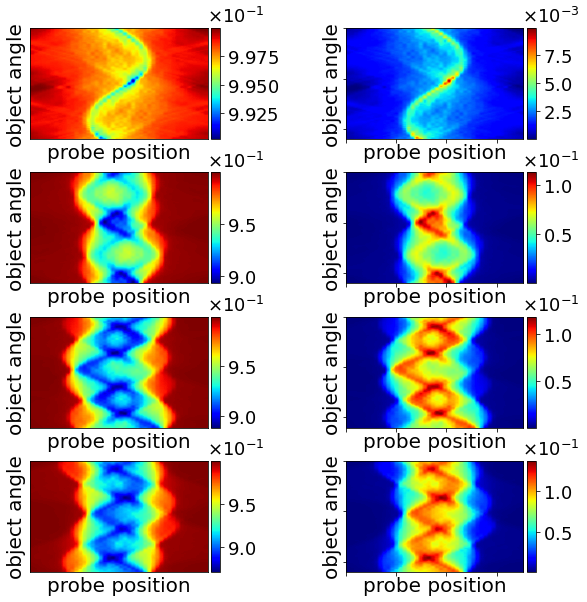

In [67]:
n_elements = len(this_aN_dic)
layer_idx_ls = np.arange(0,20,5)
# layer_idx_ls = np.array([30, 40])
n_theta_cpu =  n_theta.to("cpu")
n_theta_ds_factor = 1

# XRT_data = np.load(os.path.join(data_path, f_XRT_data) + '.npy').astype(np.float32)
with h5py.File(os.path.join(data_path, f_XRT_data +'.h5'), "r") as s:
    XRT_data = s["exchange/data"][...].astype(np.float32)
print(XRT_data.shape)
fig6 = plt.figure(figsize=(10, 10))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=2)

gs6.update(wspace=0.3, hspace=0.3)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = XRT_data[3, ::n_theta_ds_factor, layer_idx]
#     XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
    fig6_ax1 = fig6.add_subplot(gs6[idx, 0])
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', extent=[0, 176, 110, 0], origin='upper')

    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([0, 100, 200, 300])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=18) 
    fig6_ax1.set_xlabel("probe position", fontsize=20)
    fig6_ax1.set_ylabel("object angle", fontsize=20)  
    
    ## change the base of the scientific notation from "e" to "10"
    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = fig6.colorbar(pos, cax=cax, format=fmt) 

    ## Change the size of the base of the scientific notation 
    cbar.ax.yaxis.get_offset_text().set_fontsize(18)

    ## Move the base of the scientific notation to the bottom of the colorbar
    def register_bottom_offset(axis, func):
        axis._update_offset_text_position = types.MethodType(func, axis)    
    register_bottom_offset(cbar.ax.yaxis, bottom_offset)  

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = sample_size_n * layer_idx
    probe_pos_end = sample_size_n * (layer_idx + 1)
    XRT_data_ds = -np.log(XRT_data[3, ::n_theta_ds_factor, layer_idx])
#     XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
#     XRT_data_ds = np.transpose(XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end], (1,0))
    fig6_ax2 = fig6.add_subplot(gs6[idx, 1])
    pos = fig6_ax2.imshow(XRT_data_ds, cmap='jet', extent=[0, 176, 110, 0], origin='upper')

    plt.setp(fig6_ax2.get_xticklabels(), visible=False)
    plt.setp(fig6_ax2.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ticks = np.array([0, 100, 200, 300])
#     cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=18) 
    fig6_ax2.set_xlabel("probe position", fontsize=20)
    fig6_ax2.set_ylabel("object angle", fontsize=20)
    
    ## change the base of the scientific notation from "e" to "10"
    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = fig6.colorbar(pos, cax=cax, format=fmt) 

    ## Change the size of the base of the scientific notation 
    cbar.ax.yaxis.get_offset_text().set_fontsize(18)

    ## Move the base of the scientific notation to the bottom of the colorbar
    def register_bottom_offset(axis, func):
        axis._update_offset_text_position = types.MethodType(func, axis)    
    register_bottom_offset(cbar.ax.yaxis, bottom_offset)  

plt.savefig(os.path.join(data_path, 'reconstructed_XRT_sinogram.pdf'), format='pdf', dpi=600)

# Plot the ground truth if using a simulated dataset

In [120]:
grid_path = "./data/sample8_size_64_pad/nElements_2"
f_grid = "grid_concentration.npy"
# f_grid = "density_n_element_2"

## plot the ground truth - layer sectioning

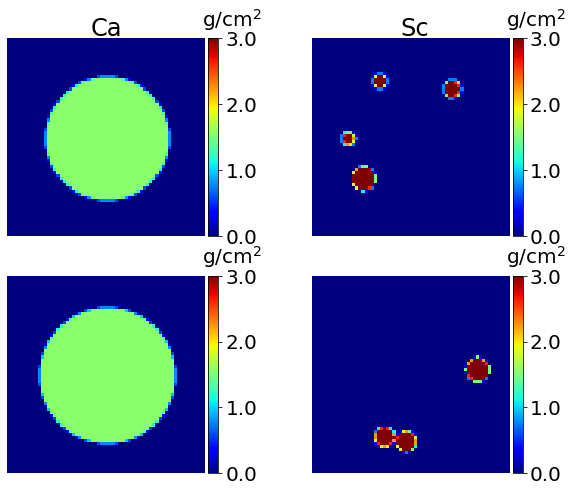

In [131]:
gt = np.load(os.path.join(grid_path, f_grid))
# with h5py.File(os.path.join(data_path, f_grid +'.h5'), "r") as s:
#     gt = s["sample/densities"][...].astype(np.float32)
#     #shape=(n_lines, n_theta, sample_height_n, sample_size_n)
#     print(XRF_data.shape)

# layer_idx_ls = np.arange(0,128,32)
layer_idx_ls = np.array([30, 40])

image_size = gt.shape[-1]
fig6 = plt.figure(figsize=(5 * gt.shape[0] , 4 * len(layer_idx_ls)))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = gt.shape[0], width_ratios=[1] * gt.shape[0])

fig6.text(0.27, 0.885, 'Ca', color='black', fontsize=24)
fig6.text(0.70, 0.885, 'Sc', color='black', fontsize=24)

for element_idx in range(gt.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(gt[element_idx,layer_idx], cmap='jet', vmin=0, vmax=3, extent=[0, image_size, image_size, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0, 4, 1)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        
        cbar.ax.set_yticklabels(["{:.1f}".format(i) for i in ticks])
        cbar.ax.tick_params(labelsize=20) 
        
        ## Move the label of the colorbar to the wanted position
        cbar.set_label(r'$\rm{g}/$'+r'$\rm{cm}^{2}$', y=1.16, ha='right', rotation=0, va='top', size='20') 

## plot the ground truth - projection view

In [52]:
grid_path = "./data/sample8_size_64_pad/nElements_2"
f_grid = "grid_concentration.npy"

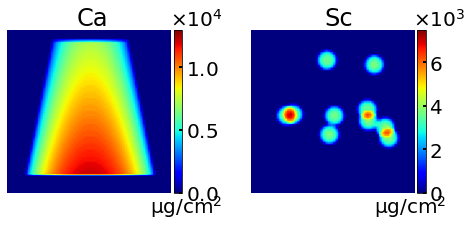

In [55]:
fraction_of_pi = 0.
projection_angle_degree = 0.

vmax_element_ls = [13000, 7500]
projection_angle_rad = tc.tensor(projection_angle_degree * (np.pi/180.))
gt = np.load(os.path.join(grid_path, f_grid))
gt_rot = rotate(tc.from_numpy(gt).float(), projection_angle_rad, "cpu")
gt_rot = gt_rot.numpy()

smaple_height = gt_rot.shape[1]
image_size = gt_rot.shape[-1]

## convert the unit to ug/cm^2
gt_rot_proj = np.sum(gt_rot, axis=-1)*np.array((sample_size_cm/sample_size_n))*10**6

## convert the unit to g/cm^2
# gt_rot_proj = np.sum(gt_rot, axis=-1)*np.array((sample_size_cm/sample_size_n))

fig6 = plt.figure(figsize=(4 * recon.shape[0]  , 3))
gs6 = gridspec.GridSpec(nrows= 1, ncols = gt.shape[0], width_ratios=[1] * gt.shape[0])

fig6.text(0.27, 0.9, 'Ca', color='black', fontsize=24)
fig6.text(0.70, 0.9, 'Sc', color='black', fontsize=24)

# fig6.text(0.45, 0.9, 'Si', color='black', fontsize=24)


for element_idx in range(gt.shape[0]):
    fig6_ax1 = fig6.add_subplot(gs6[0, element_idx])
    fig6_ax1.set_xticks(np.arange(0, image_size, 1))
    fig6_ax1.set_yticks(np.arange(0, image_size, 1))
#     fig6_ax1.grid(color='w', linewidth=2)
    fig6_ax1.axis('off')
#     pos = fig6_ax1.imshow(gt_rot_proj[element_idx], cmap='jet', vmin=0, vmax=np.max(gt_rot_proj), extent=[0, image_size, smaple_height, 0], origin='upper')
    pos = fig6_ax1.imshow(gt_rot_proj[element_idx], cmap='jet', vmin=0, vmax=vmax_element_ls[element_idx], extent=[0, image_size, smaple_height, 0], origin='upper')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#         ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
#         cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar = fig6.colorbar(pos, cax=cax)    
   
    
    ## set the fontsize of the tick label
    cbar.ax.tick_params(labelsize=20, direction='in', width=2)
    ## set the linewidth of the colorbar box
    cbar.outline.set_linewidth(2)
    
    ## change the base of the scientific notation from "e" to "10"
    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = fig6.colorbar(pos, cax=cax, format=fmt) 
    
    ## Change the size of the base of the scientific notation 
    cbar.ax.yaxis.get_offset_text().set_fontsize(20)
    
    ## Move the base of the scientific notation to the bottom of the colorbar
    def register_bottom_offset(axis, func):
        axis._update_offset_text_position = types.MethodType(func, axis)    
    register_bottom_offset(cbar.ax.yaxis, bottom_offset)    
    
    ## Move the label of the colorbar to the wanted position
#     cbar.set_label(r'$\rm{g}/$'+r'$\rm{cm}^{2}$', y=1.16, ha='right', rotation=0, va='top', size='20')        
    cbar.set_label(r'$\rm{\mu}$g/'+r'$\rm{cm}^{2}$', y=-0.00, ha='right', rotation=0, va='top', size='20')
    
plt.savefig(os.path.join(grid_path, f'gt_projection_{fraction_of_pi}.pdf'))

In [350]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma


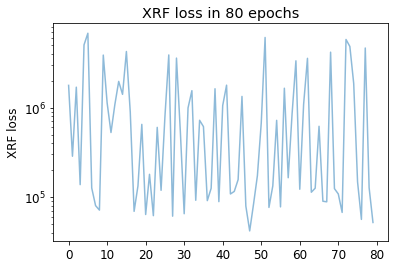

In [18]:
loss = np.load("./data/Xtal1_align1_adjusted1_ds4_recon/Ab_T_nEl_4_Dis_2.0_nDpts_4_b1_1.0_b2_25000_lr_1.0E-3_manual_Iprobe_1e6/XRF_loss_signal.npy")
loss_moving_ave = movingaverage(loss, 110)

plt.title("XRF loss in 80 epochs")
plt.plot(loss[::110], alpha = 0.5)
# plt.plot(loss, alpha = 0.5)
plt.ylabel("XRF loss")
plt.yscale('log')

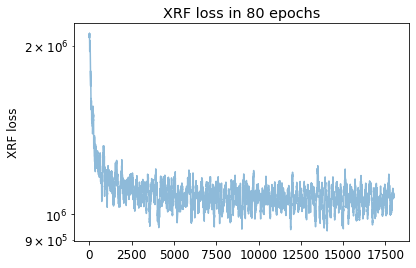

In [358]:
loss = np.load("./data/Cabead_adjusted1_ds4_recon/Ab_F_nEl_6_nDpts_4_b1_0.0_lr_1.0E-3/XRF_loss_signal.npy")
loss_moving_ave = movingaverage(loss, 110)

plt.title("XRF loss in 80 epochs")
plt.plot(loss_moving_ave, alpha = 0.5)
# plt.plot(loss, alpha = 0.5)
plt.ylabel("XRF loss")
plt.yscale('log')

No handles with labels found to put in legend.


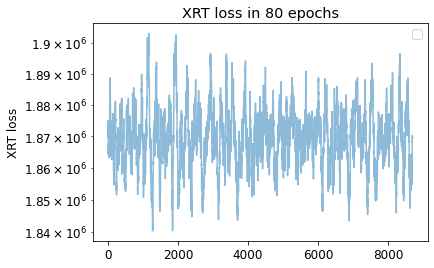

In [13]:
loss = np.load("./data/Xtal1_align1_adjusted1_ds4_recon_h5test/Ab_T_nEl_4_Dis_2.0_nDpts_4_b1_1.0_b2_25000_lr_1.0E-3_manual_Iprobe_1e6/XRT_loss_signal.npy")
loss_moving_ave = movingaverage(loss, 110)

plt.title("XRT loss in 80 epochs")
# plt.plot(loss[::110], alpha = 0.5)
plt.plot(loss_moving_ave, alpha = 0.5)
plt.ylabel("XRT loss")
plt.yscale('log')
plt.legend()


No handles with labels found to put in legend.


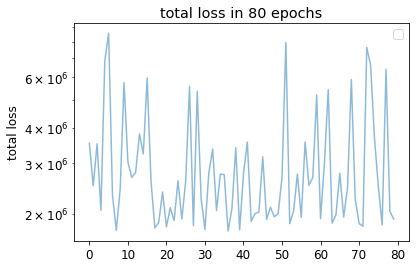

In [8]:
loss = np.load("./data//Xtal1_align1_adjusted1_ds4_recon_h5test/Ab_T_nEl_4_Dis_2.0_nDpts_4_b1_1.0_b2_25000_lr_1.0E-3_manual_Iprobe_1e6/loss_signal.npy")
loss_moving_ave = movingaverage(loss, 110)
plt.title("total loss in 80 epochs")
plt.plot(loss[::110], alpha = 0.5)
plt.ylabel("total loss")
plt.yscale('log')
plt.legend()

In [227]:
s = [0] * -3

In [228]:
s

[]